# Repeat Until Success

**Download this notebook - {nb-download}`repeat-until-success.ipynb`**

This notebook implements the single-qubit unitary $V_3 = R_z(-2\arctan(2)) = (I + 2iZ)/\sqrt{5}$ using a repeat-until-success (RUS) scheme from [arXiv:1311.1074](https://arxiv.org/abs/1311.1074). More specifically, we will implement in Guppy the scheme with a particularly low expected $T$ count, in this case the circuit from *Fig. 1c*:

![](./img/rus_circuit.png){w=240px align=center}

The aim is to showcase how such a scheme translates into Guppy using [control flow](https://docs.quantinuum.com/guppy/language_guide/control_flow.html), and how we can experiementally validate the success rate of $5/8$ provided in the paper.

## Implementation

The repeat-until-success scheme in use specifies that we must run the circuit from [arXiv:1311.1074](https://arxiv.org/abs/1311.1074) *Fig. 1c* until both $X$-basis measurements return the $0$ outcome. In Guppy, we can implement this with an endless loop that resumes iteration on failure, and otherwise assumes success and breaks.

In particular, the circuit has the nice property that if one of the measurements does not return $0$ the circuit implements the identity, so we can reset the ancilla qubits without recovery on the data qubit.

In [1]:
from guppylang import guppy
from guppylang.std.builtins import result
from guppylang.std.quantum import measure, qubit, discard, h, tdg, cx, t, z

@guppy
def repeat_until_success(q: qubit) -> None:
    attempts = 0
    while True:
        attempts += 1

        # Prepare ancilla qubits
        a, b = qubit(), qubit()
        h(a)
        h(b)

        tdg(a)
        cx(b, a)
        t(a)
        h(a)
        if measure(a):
            # First ancilla failed, consume all ancillas, try again
            discard(b)
            continue

        t(q)
        z(q)
        cx(q, b)
        t(b)
        h(b)
        if measure(b):
            # Second ancilla failed, try again
            continue

        result("attempts", attempts)
        break
repeat_until_success.check()

## Usage and Results

We can now use the unitary that is implemented by the RUS scheme in another Guppy function. We prepare a $\ket{0}$ state on a fresh qubit and apply the unitary. For this demonstration we are only interested in the number of iterations required for the unitary to be implemented, so we consume the qubit by discarding it.

In [2]:
from guppylang.std.quantum import x

@guppy
def main() -> None:
    q = qubit()
    repeat_until_success(q)
    discard(q)


To test the finished Guppy program, we create an emulator with the maximum number of qubits allocated and simulate a few shots. We bin the number of shots according to the number of attempts they required to implement the unitary, and see that the majority of shots realizes the unitary on the first try. To increase the probability of this happening one may employ strategies further described in [arXiv:1311.1074](https://arxiv.org/abs/1311.1074), but this is beyond the scope of this example.

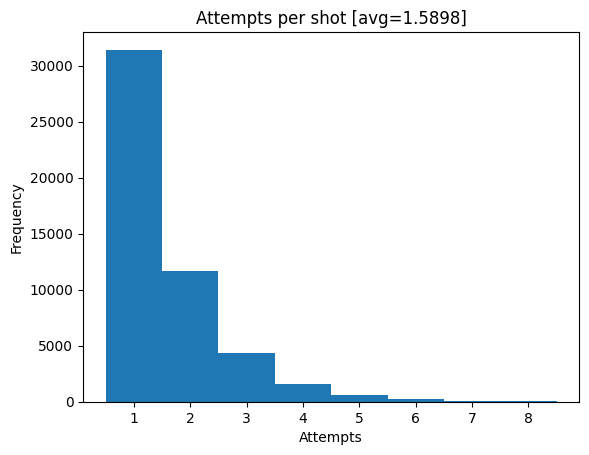

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

shots = main.emulator(n_qubits=3).with_seed(0).with_shots(50000).run()
attempts = [int(shot.as_dict()["attempts"]) for shot in shots]
avg_attempts = sum(attempts) / len(shots)

fig, ax = plt.subplots(1, 1)
ax.hist(attempts, bins=np.array(range(1, 10)) - 0.5)
ax.set_title(f"Attempts per shot [avg={avg_attempts}]")
ax.set_xlabel("Attempts")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
plt.show()

Finally, inverting the average number of shots required yields the experimental success rate for the implemented scheme. Following the Law of Large Numbers, increasing the number of shots yields a better approximation to the true success rate, which we can compare to the analytic success rate of $5/8$ provided in [arXiv:1311.1074](https://arxiv.org/abs/1311.1074).

In [4]:
def exp_with_shots(n_shots: int) -> None:
    shots = main.emulator(n_qubits=3).with_seed(0).with_shots(n_shots).run()
    attempts = [int(shot.as_dict()["attempts"]) for shot in shots]
    total_attempts = sum(attempts)
    print(f" Shots: {n_shots} ".center(50, "-"))
    print(f"Average attempts: {total_attempts / len(shots)}")
    print(f"Predicted rate: {len(shots) / total_attempts}")

print(f"Analytic rate: {5/8}")
exp_with_shots(100)
exp_with_shots(1000)
exp_with_shots(10000)

Analytic rate: 0.625
------------------- Shots: 100 -------------------
Average attempts: 1.49
Predicted rate: 0.6711409395973155
------------------ Shots: 1000 -------------------
Average attempts: 1.545
Predicted rate: 0.6472491909385113
------------------ Shots: 10000 ------------------
Average attempts: 1.5842
Predicted rate: 0.6312334301224592
